# Q&A with BERT-Finetuned

We will pre-train the BERT model on the [SQuAD1.0](https://rajpurkar.github.io/SQuAD-explorer/) dataset, consisting of questions asked by crowdworkers on a set of Wikipedia articles.

Encoder-only models such as BERT are generally excellent at extracting answers to factoid questions like “Who invented the Transformer architecture?”, but poorly at open-ended questions like “Why is the sky blue?”. In such complex cases, encoder-decoder models such as T5 and BART are typically used to synthesize information

## Installing libraries

In [ ]:
!pip install --upgrade datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
!git config --global user.email "nesterenkoms2001@gmail.com"
!git config --global user.name "MaksimNS01"

## Import libraries and modules

In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForQuestionAnswering
import collections
import tensorflow as tf
from transformers import TFAutoModelForQuestionAnswering
import numpy as np
import evaluate
from tqdm.auto import tqdm
from transformers import TrainingArguments
from transformers import Trainer
from accelerate import Accelerator
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from transformers import get_scheduler
from huggingface_hub import Repository, get_full_repo_name
from transformers import pipeline

## Authorization in HuggingFace

In [ ]:
notebook_login()

## Loading and analyzing the SQuAD dataset

In [ ]:
raw_datasets = load_dataset("squad")

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

It looks like we have everything we need in the context, question, and answers fields, so let's output them for the first element of our training set:

In [ ]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


The context and question fields are very easy to use. The answers field is a bit more complicated because it is a dictionary with two fields that are both lists. This is the format that the squad metric will expect when evaluating. The text field is fairly obvious, and the answer_start field contains the index of the starting character of each answer in the context.

During training, there is only one possible answer. We can double-check this using the Dataset.filter() method:

In [ ]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

For evaluation, however, there are several possible answers for each example, which may be the same or different:

In [ ]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


 The idea is that some questions have multiple possible answers, and this script will compare the predicted answer with all the valid answers and choose the best result. If we look, for example, at a sample with an index of 2:

In [ ]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Where did Super Bowl 50 take place?


The answer may indeed be one of the three possible options we saw earlier.

## Preparing training data

First, we need to convert the text in the input data into identifiers that the model can understand using the tokenizer:

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

To check that the tokenizer object being used is actually supported, its is_fast attribute is used:

In [ ]:
tokenizer.is_fast

True

We can pass our tokenizer the question and context together, and it will correctly insert special tokens to form a sentence like this one:

In [ ]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building \' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

The indices of tokens starting and ending a response will be used as labels, and the task of the model is to predict one starting and ending logit for each token in the input, with the theoretical labels as follows:

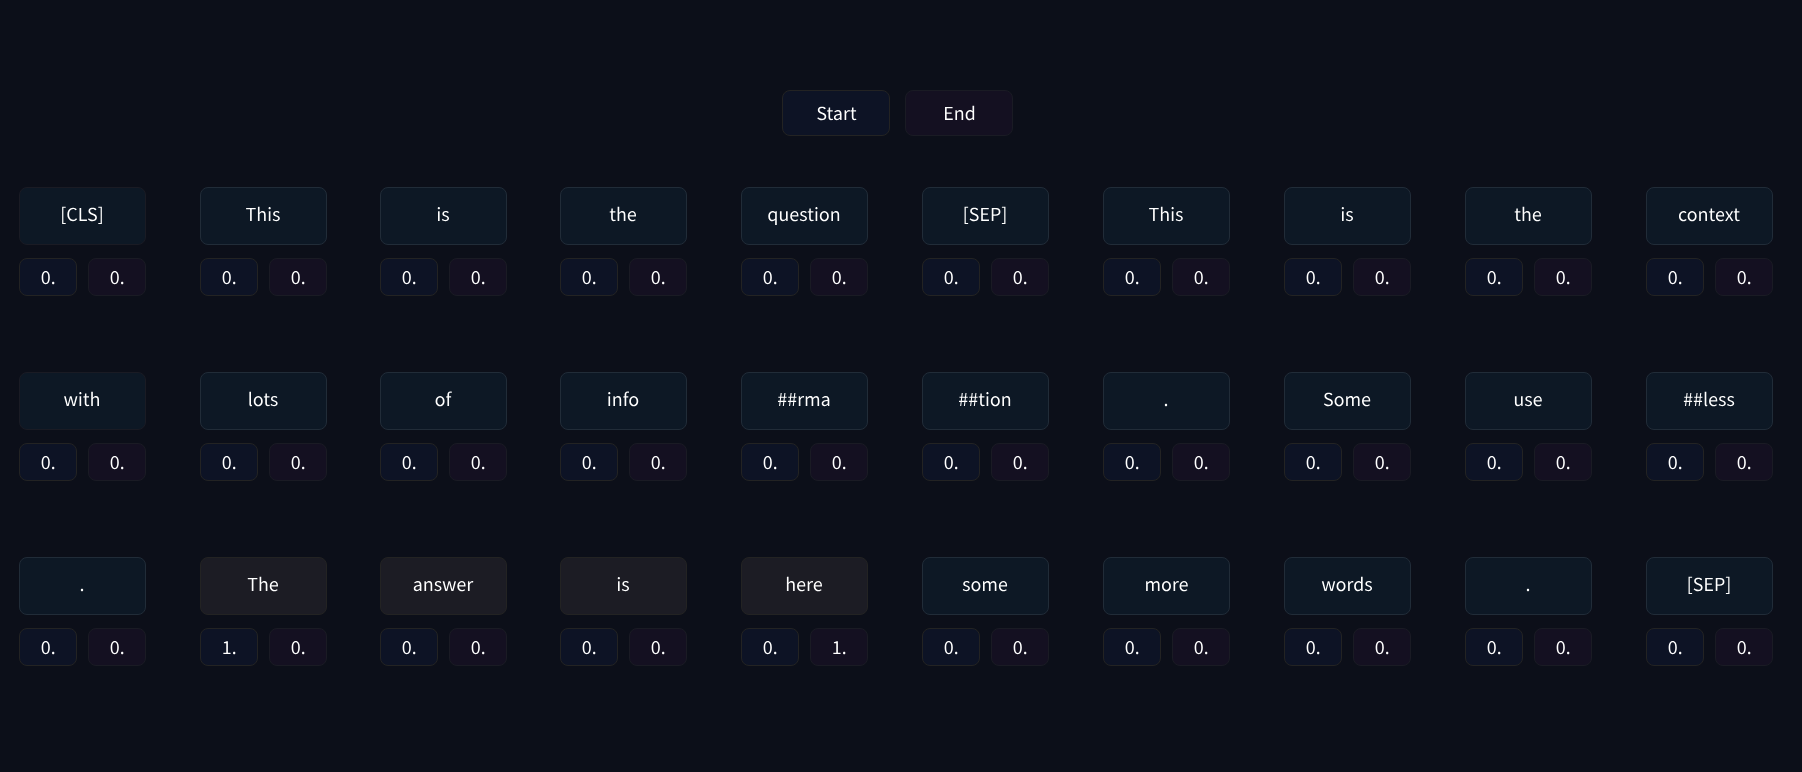

In this case, the context is not too long, but some examples in the dataset have very long contexts that will exceed the maximum length we set (which in this case is 384).

To see how this works for the current example, we can limit the length to 100 and use a sliding window of 50 tokens. We use:
* max_length (we'll take 100)
* truncation="only_second" to truncate the context (which is in the second position) when a question with its context is too long
* stride to set the number of overlapping tokens between two consecutive fragments (let's take 50)
* return_overflowing_tokens=True to tell the tokenizer that we need overflowing tokens (overflowing tokens)

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the

As we can see, our example has been split into four inputs, each containing a question and a piece of context. The answer to the question (“Bernadette Soubirous”) only appears in the third and last input, so by working with long contexts in this way, we will create some training examples in which the answer is not included in the context. For these examples, the labels will be start_position = end_position = 0 (this is how we predict the [CLS] token). We will also set these labels in the unfortunate case where the response has been truncated so that we only have its start (or end). For examples where the response is entirely in context, the labels will be the index of the token where the response begins and the index of the token where the response ends.

The dataset gives us the starting character of the answer in context, and by adding the length of the answer to it, we can find the ending character in context. To map these to token indices, we need to use offset mapping6. We can configure our tokenizer to return them by passing return_offsets_mapping=True:

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

As we can see, we get back the usual input identifiers, token type identifiers and attention mask, as well as the offset mapping we need and an additional overflow_to_sample_mapping key. We will use the corresponding value when tokenizing multiple texts at the same time (which we must do to take advantage of the fact that our tokenizer is Rust-based). Since a single pattern can produce multiple features, it maps each feature to the example from which it originated. Since we have only tokenized one example here, we will get a list of 0:

In [ ]:
inputs["overflow_to_sample_mapping"]

[0, 0, 0, 0]

But if we tokenize more examples, it will become more efficient:

In [ ]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


As we can see, the first three examples (with indices 2, 3, and 4 in the training set) produced four features each, and the last example (with index 5 in the training set) produced 7 features.

This information will be useful for matching each obtained feature with the corresponding label. These labels are:

* (0, 0) if the answer is not in the corresponding context area
* (start_position, end_position) if the answer is in the corresponding context area, with start_position being the token index (in input identifiers) at the beginning of the answer and end_position being the token index (in input identifiers) at the end of the answer.

To determine which of these cases occurs and, if necessary, the positions of the tokens, we first find the indices where the context begins and ends in the input identifiers. We could use token type identifiers for this, but since they don't necessarily exist for all models (for example, DistilBERT doesn't require them), we'll instead use the sequence_ids() method from BatchEncoding, which returns our tokenizer.

Once we have the token indices, we look at the corresponding offsets, which are tuples of two integers denoting the character spacing within the original context. In this way, we can determine whether the context fragment in this token begins after the response or ends before the response begins (in which case the label would be (0, 0)). If it does not, we loop to find the first and last token of the response:

In [ ]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Let's find the beginning and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the response is not completely within context, the label will be (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise, these are the start and end positions of the tokens
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

Let's look at a few results to see if our approach is correct. For the first feature we find (83, 85) as labels, so let's compare the theoretical answer with the decoded range of tokens 83 through 85 (inclusive):

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

Theoretical answer: the Main Building, labels give: the Main Building


So that's a match! Now let's check index 4, where we set the labels to (0, 0), which means that the answer is not in the context fragment of this feature:

In [ ]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: a Marian place of prayer and reflection, decoded example: [CLS] What is the Grotto at Notre Dame? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building ' s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grot [SEP]


There is no answer in context.

Now that we've dealt with the preprocessing of the training data step by step, we can group it into a feature that we'll apply to the entire dataset. We will augment each feature to the maximum length we have set, as most contexts will be long (and the corresponding samples will be split into multiple features), so applying dynamic augmentation is of no real use here:

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Let's find the beginning and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the response is not completely within context, the label will be (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise, these are the start and end positions of the tokens
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Note that we defined two constants to define the maximum length and the sliding window length, and added some cleanup before tokenization: some questions in the SQuAD dataset have extra spaces at the beginning and end that don't add anything, so we removed those extra spaces.

To apply this feature to the entire training set, we use the Dataset.map() method with the batched=True flag. This is necessary because we change the length of the dataset (since one example can produce multiple training features):

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

As we can see, the preprocessing has added about 1,000 features. Now our training set is ready for use. Let's move on to preprocessing of the validation set.

## Preparing validation data

Pre-processing validation data will be a bit easier since we don't need to generate labels. The real joy will be interpreting the model predictions in the ranges of the original context. To do this, we need to store both offset mappings and a way to map each generated feature to the original example from which it is taken. Since the original dataset has an ID column, we will use that ID.

We need to clean up the offset mappings. They will contain offsets for the question and context, but at post-processing stage we will have no way to know which part of the input identifiers corresponds to the context and which to the question (the sequence_ids() method we used is only available for tokenizer output). Therefore, we will set the offsets corresponding to the question to None:

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

In this case, we only added a couple hundred examples, so the contexts in the validation dataset are a bit shorter.

Now that we have pre-processed all the data, we can start training.

## Fine-Tuning

### Post-processing

The model will output the logits for the start and end positions of the response in the input identifiers.

To speed up the process, we will also not estimate all possible pairs (start_token, end_token), but only those corresponding to the largest n_best logits (with n_best=20). Since we will skip softmax, these estimates will be logit estimates, and will be obtained by taking the sum of the start and end logits (instead of the product, by the rule \(\log(ab) = \log(a) + \log(b)\)).

To demonstrate all of this, we will need some predictions. Since we haven't trained our model yet, we will use the default model for the QA pipeline to generate some predictions on a small portion of the validation set. We can use the same processing function as before; since it relies on the global constant tokenizer, we just need to change that object to the tokenizer of the model we want to use temporarily:

In [ ]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Now that preprocessing is complete, we change the tokenizer back to the one originally selected:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Then we remove the columns from our eval_set that the model doesn't expect, create a batch with all that little validation, and run it through the model.

In [ ]:
eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

Since Trainer will return our predictions to us as NumPy arrays, we take the start and end logits and convert them to this format:

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

Now we need to find the predicted answer for each example in small_eval_set. One example can be split into multiple features in eval_set, so the first step is to map each example in small_eval_set to the corresponding features in eval_set:

In [ ]:
example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

With this in hand, we can proceed by iterating over all examples and, for each example, all associated features. As we said, we consider logit estimates for n_best initial logits and final logits, excluding items that give:

An answer that does not fit into the context
An answer with negative length
An answer that is too long (we limit the possibilities by max_answer_length=30).
Once we have all possible answers for a single example, we simply select the one with the best logit score:

In [ ]:
n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that do not fully match the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip responses that are either < 0 or > max_answer_length
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

The final format of the predicted responses is the one expected by the metric we will use. As usual, we can load it using the Evaluate library:

In [ ]:
metric = evaluate.load("squad")

This metric expects predicted answers in the format we saw above (a list of dictionaries with one key for the example ID and one key for the predicted text) and theoretical answers in the format below (a list of dictionaries with one key for the example ID and one key for possible answers):

In [ ]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

We can now verify that we are getting reasonable results by looking at the first element of both lists:

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


That's not too bad! Now let's look at the score that the metric gives us:

In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

Now let's put everything we just did into the compute_metrics() function that we will use in Trainer. Normally, compute_metrics() only gets the eval_preds tuple with logits and labels. Here we'll need a bit more than that, since we have to look in the bias trait dataset and in the example dataset for the original contexts, so we won't be able to use this function to get the usual eval results during training. We will only use it at the end of training to check the results.

The compute_metrics() function groups the same steps as before, only a small check is added in case we do not find any correct answers (in which case we predict an empty string).

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Iterate over all the features associated with this example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that don't fully fit the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip responses whose length is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Choose the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

Looks great! Now let's use this to pre-train our model.

### Model retraining

Now we are ready to train our model. Let's first create it using the AutoModelForQuestionAnswering class as before:

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

As usual, we get a warning that some weights are not used (pre-training head weights) and others are initialized randomly (question answering head weights). You should be used to this by now, but it means that the model is not yet ready to be used and needs to be pre-trained - good thing we are about to do that!

We can define our TrainingArguments. As we said when we defined our function to compute a metric, we won't be able to do a normal evaluation loop because of the signature of compute_metrics(). We could write our own Trainer subclass for this, but that's too long for this section. Instead, we will only evaluate the model at the end of training, and we will show how to do regular evaluation below in the section “Custom Training Loop”.

In [ ]:
args = TrainingArguments(
    "bert-finetuned-squad",
    # evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

Finally, we just pass everything to the Trainer class and run the training:

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

When training is complete, we can finally evaluate our model (and pray we didn't waste all that computation time). The predict() method of the Trainer function will return a tuple where the first elements are the model predictions (here a pair with the initial and final logits). We send it to our compute_metrics() function:

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

Great!!! For comparison, the baseline numbers listed in the BERT article for this model are 80.8 and 88.5, so we're right where we should be.

Finally, we use the push_to_hub() method to make sure we have loaded the latest version of the model:

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Maksim01gh/bert-finetuned-squad/commit/0fc95b475b1a0cea2a66b443a39814a6d2805e57', commit_message='Training complete', commit_description='', oid='0fc95b475b1a0cea2a66b443a39814a6d2805e57', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Maksim01gh/bert-finetuned-squad', endpoint='https://huggingface.co', repo_type='model', repo_id='Maksim01gh/bert-finetuned-squad'), pr_revision=None, pr_num=None)

This returns the URL of the commit that was just executed.

Trainer also creates a draft model card with all of the evaluation results and uploads it.

### Training Cycle

First we need to create DataLoaders from our datasets. We will set the format of these datasets to “torch” and remove columns in the validation set that are not used by the model. Then we can use the default_data_collator provided by Transformers as collate_fn and mix the training set but not the validation set:

In [ ]:
train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

We then reinstantiate our model to ensure that we do not continue pre-training, but start again with the pre-trained BERT model:

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then we need an optimizer. As usual, we use the classic AdamW, which is similar to Adam, but with a fix in the way weight attenuation is applied:

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
# accelerator = Accelerator(fp16=True)
accelerator = Accelerator(mixed_precision="fp16")
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

We can use the length of train_dataloader to compute the number of training steps only after it passes through the accelerator.prepare() method. We use the same line graph as in the previous sections:

In [ ]:
num_train_epochs = 2
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

To send our model to the Hub, we need to create a Repository object in the working folder. First, log into the Hugging Face Hub if you are not already logged in. We'll define the name of the repository by the model ID we want to assign to our model (feel free to replace repo_name with your own; it just needs to contain your username, which is what get_full_repo_name() does):

In [ ]:
model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'Maksim01gh/bert-finetuned-squad-accelerate'

The code below will cause a “Repo not found” error. The HuggingFace community has found the following solution to the problem:
* Go to the last line of the error and find which repository is not found.
* Go to [Hugging Face - The AI community building the future](https://huggingface.co/new) to create the repository that is missing.
* Run the code again

In [ ]:
output_dir = "bert-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Maksim01gh/bert-finetuned-squad-accelerate into local empty directory.


# Training cycle

We are now ready to write a complete training cycle. After defining a progress bar to keep track of the training progress, the loop consists of three parts:

Training proper, which is a classical iteration on train_dataloader, a forward pass through the model, then a backward pass and an optimizer step.
Evaluation, in which we collect all the values for start_logits and end_logits before converting them into NumPy arrays. Once the evaluation loop is complete, we combine all the results. Note that we need to do truncation because Accelerator may add some examples at the end to make sure we have the same number of examples in each process.
Saving and loading, where we first save the model and tokenizer, and then call repo.push_to_hub(). As before, we use the blocking=False argument to tell the 🤗 Hub library to push asynchronously. This way, the learning continues normally and this (long) instruction is executed in the background.
Here is the full code for the learning loop:

In [ ]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

# Using the Fine-Tuned Model

To use it locally in the pipeline, you just need to specify the model ID:

In [ ]:
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""

Device set to use cuda:0


In [ ]:
# List of questions
questions = [
    "Which deep learning libraries back Transformers?",
    "How many popular deep learning libraries support Transformers?",
    "Can you switch between libraries after training a model?",
    "Name a library that integrates with Transformers other than PyTorch.",
    "What is the main advantage of Transformers' library integration?"
]

# Run a model for each question
for question in questions:
    result = question_answerer(question=question, context=context)
    print(f"Question: {question}")
    print(f"Answer: {result['answer']} (score: {result['score']:.4f})\n")

Вопрос: Which deep learning libraries back Transformers?
Ответ: Jax, PyTorch and TensorFlow (score: 0.9982)

Вопрос: How many popular deep learning libraries support Transformers?
Ответ: three (score: 0.9982)

Вопрос: Can you switch between libraries after training a model?
Ответ: It's straightforward (score: 0.2549)

Вопрос: Name a library that integrates with Transformers other than PyTorch.
Ответ: TensorFlow (score: 0.9776)

Вопрос: What is the main advantage of Transformers' library integration?
Ответ: It's straightforward to train your models with one (score: 0.0449)



Great! Our model works just as well as the default model for this pipeline!